In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
import numpy as np

In [3]:
# --- Install dependencies (run once) ---
# !pip install torch torch-geometric transformers sentence-transformers scikit-learn pandas numpy

# === Step 1: Load and Clean Data ===
df = pd.read_csv("Data_Breaches_K.csv")

# Drop rows with missing crucial values
df = df.dropna(subset=["Type of breach", "Sector", "Severity", "Year of Breach", "Records Exposed"])
df["Year of Breach"] = pd.to_numeric(df["Year of Breach"], errors='coerce')
df["Records Exposed"] = pd.to_numeric(df["Records Exposed"], errors='coerce')
df = df.dropna(subset=["Year of Breach", "Records Exposed"])

# === Step 2: Encode and Scale ===
le_sector = LabelEncoder()
df["Sector_encoded"] = le_sector.fit_transform(df["Sector"])

scaler = MinMaxScaler()
df["Year_scaled"] = scaler.fit_transform(df[["Year of Breach"]])
df["Records_scaled"] = scaler.fit_transform(df[["Records Exposed"]])

# === Step 3: BERT Embeddings for Breach Type ===
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
bert_embeddings = bert_model.encode(df["Type of breach"].tolist(), convert_to_tensor=True)
bert_embeddings = bert_embeddings.cpu().numpy()

# === Step 4: Combine All Features ===
feature_matrix = np.concatenate(
    [bert_embeddings,
     df[["Sector_encoded", "Year_scaled", "Records_scaled"]].values],
    axis=1
)
knn_graph = kneighbors_graph(feature_matrix, n_neighbors=8, mode='connectivity', include_self=False)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

# === Step 5: Prepare GCN Input ===
X = torch.tensor(feature_matrix, dtype=torch.float)
y = LabelEncoder().fit_transform(df["Severity"])
y = torch.tensor(y, dtype=torch.long)

train_mask, test_mask = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)
train_mask_t = torch.zeros(len(y), dtype=torch.bool)
test_mask_t = torch.zeros(len(y), dtype=torch.bool)
train_mask_t[train_mask] = True
test_mask_t[test_mask] = True

data = Data(x=X, edge_index=edge_index, y=y)
data.train_mask, data.test_mask = train_mask_t, test_mask_t

# === Step 6: Define Enhanced GCN ===
class EnhancedGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(EnhancedGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim // 2)
        self.conv3 = GCNConv(hidden_dim // 2, num_classes)
        self.dropout = torch.nn.Dropout(p=0.4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# === Step 7: Train Model ===
model = EnhancedGCN(input_dim=data.num_features, hidden_dim=128, num_classes=len(torch.unique(data.y)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
losses = []  # <-- Add this before training loop

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    losses.append(loss.item())  # <-- Track loss
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


# === Step 8: Evaluate ===
model.eval()
_, pred = model(data).max(dim=1)
test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
test_acc = test_correct / data.test_mask.sum().item()

print(f"\n✅ Final Enhanced GCN Accuracy: {test_acc:.3f}\n")

# === Step 9: Classification Report ===
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Low", "Medium", "High"]))


c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_core

Epoch 0, Loss: 0.9455
Epoch 20, Loss: 0.6094
Epoch 40, Loss: 0.4935
Epoch 60, Loss: 0.4072
Epoch 80, Loss: 0.3239

✅ Final Enhanced GCN Accuracy: 0.913

📊 Classification Report:
              precision    recall  f1-score   support

         Low       0.89      1.00      0.94       575
      Medium       0.95      1.00      0.98        80
        High       1.00      0.57      0.73       169

    accuracy                           0.91       824
   macro avg       0.95      0.86      0.88       824
weighted avg       0.92      0.91      0.90       824



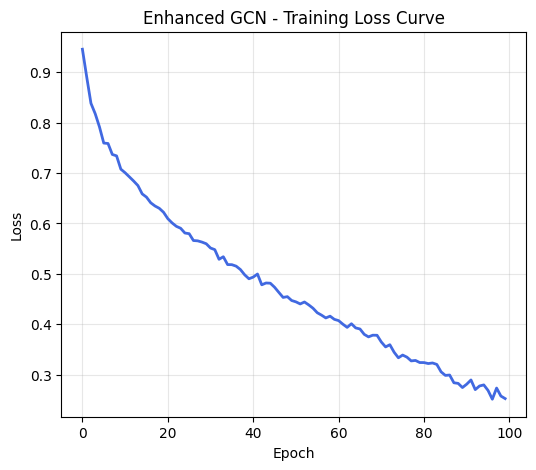

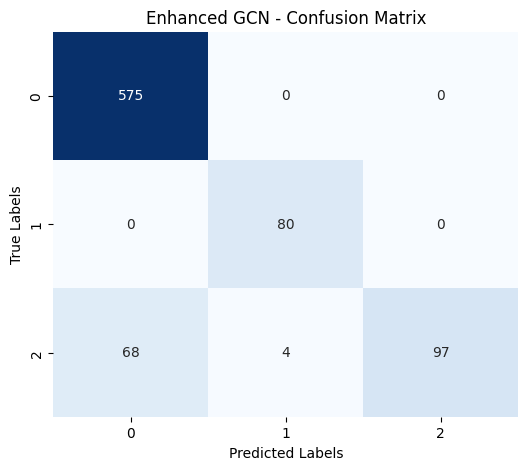

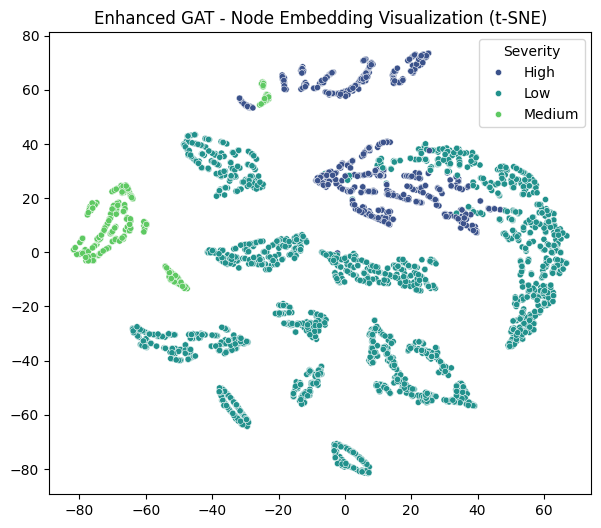

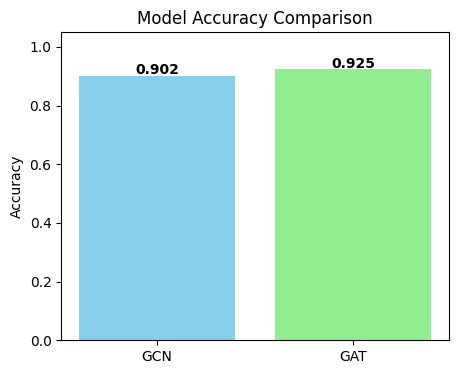

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

# ===================== 1️⃣ LOSS CURVE =====================
# (If you didn’t track it, add 'losses = []' before your training loop and append loss.item() inside.)
plt.figure(figsize=(6, 5))
plt.plot(losses, color='royalblue', linewidth=2)
plt.title("Enhanced GCN - Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

# ===================== 2️⃣ CONFUSION MATRIX =====================
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Enhanced GCN - Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ===================== 3️⃣ t-SNE NODE EMBEDDING VISUALIZATION =====================
# Visualize how GCN separates node representations in embedding space.
model.eval()
with torch.no_grad():
    embeddings = model.conv2(F.relu(model.conv1(data.x, data.edge_index)), data.edge_index)
    embeddings = embeddings.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(embeddings)

labels = ["Low", "Medium", "High"]
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    hue=[labels[i] for i in data.y.cpu().numpy()],
    palette='viridis',
    s=20
)
plt.title("Enhanced GAT - Node Embedding Visualization (t-SNE)")
plt.legend(title="Severity")
plt.show()

# ===================== 4️⃣ COMPARATIVE BAR CHART (OPTIONAL) =====================
# Compare GCN vs GAT if you store their accuracies
acc_gcn = 0.902   # replace with your actual GCN test_acc
acc_gat = 0.925  # from your earlier GAT run

plt.figure(figsize=(5, 4))
plt.bar(["GCN", "GAT"], [acc_gcn, acc_gat], color=["skyblue", "lightgreen"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
for i, acc in enumerate([acc_gcn, acc_gat]):
    plt.text(i, acc + 0.005, f"{acc:.3f}", ha='center', fontweight='bold')
plt.ylim(0, 1.05)
plt.show()


In [5]:
# --- Install dependencies (run once) ---
# !pip install torch torch-geometric transformers sentence-transformers scikit-learn pandas numpy

import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report

# === Step 1: Load and Clean Data ===
df = pd.read_csv("Data_Breaches_K.csv")
df = df.dropna(subset=["Company", "Type of breach", "Sector", "Severity", "Year of Breach", "Records Exposed"])
df["Year of Breach"] = pd.to_numeric(df["Year of Breach"], errors="coerce")
df["Records Exposed"] = pd.to_numeric(df["Records Exposed"], errors="coerce")
df = df.dropna(subset=["Year of Breach", "Records Exposed"])

# === Step 2: Company-Level Aggregation ===
agg_funcs = {
    "Records Exposed": ["mean", "max", "sum", "count"],
    "Year of Breach": ["min", "max"],
}
company_df = df.groupby("Company").agg(agg_funcs)
company_df.columns = ["_".join(col) for col in company_df.columns]

sector_map = df.groupby("Company")["Sector"].agg(lambda x: x.value_counts().index[0])
company_df["Sector"] = sector_map

# Encode sector
le_sector = LabelEncoder()
company_df["Sector_encoded"] = le_sector.fit_transform(company_df["Sector"])

# Encode target — High risk if company ever had a high-severity breach
company_df["HighRisk"] = df.groupby("Company")["Severity"].apply(lambda x: 1 if "High" in x.values else 0)

# === Step 3: BERT Embeddings for Breach Types ===
os.environ["USE_TF"] = "0"
os.environ["USE_TORCH"] = "1"
os.environ["TRANSFORMERS_NO_TF_WARNING"] = "1"

bert_model = SentenceTransformer("all-MiniLM-L6-v2")
type_embeddings = bert_model.encode(df["Type of breach"].tolist(), convert_to_numpy=True)
df["embeddings"] = list(type_embeddings)

# Average embeddings per company
company_embeddings = df.groupby("Company")["embeddings"].apply(lambda x: np.mean(np.stack(x), axis=0))
company_df = company_df.merge(company_embeddings, on="Company")

# === Step 4: Combine Features ===
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(company_df[[
    "Records Exposed_mean", "Records Exposed_max", "Records Exposed_sum",
    "Records Exposed_count", "Year of Breach_min", "Year of Breach_max", "Sector_encoded"
]])
embeddings = np.stack(company_df["embeddings"].values)
X = np.concatenate([embeddings, scaled_features], axis=1)

# === Step 5: Graph Construction ===
knn_graph = kneighbors_graph(X, n_neighbors=5, mode="connectivity", include_self=False)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

# === Step 6: Prepare PyG Data ===
X_tensor = torch.tensor(X, dtype=torch.float)
y = torch.tensor(company_df["HighRisk"].values, dtype=torch.long)

train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)
train_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

data = Data(x=X_tensor, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

# === Step 7: Define GCN Model ===
class CompanyRiskGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(CompanyRiskGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim // 2)
        self.conv3 = GCNConv(hidden_dim // 2, num_classes)
        self.dropout = torch.nn.Dropout(0.4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# === Step 8: Train ===
model = CompanyRiskGCN(input_dim=data.num_features, hidden_dim=128, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

for epoch in range(120):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# === Step 9: Evaluate ===
model.eval()
_, pred = model(data).max(dim=1)
test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
test_acc = test_correct / data.test_mask.sum().item()

print(f"\n✅ Final Company Risk GCN Accuracy: {test_acc:.3f}\n")

# Report
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Low Risk", "High Risk"]))


c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 0 | Loss: 0.6679
Epoch 20 | Loss: 0.4883
Epoch 40 | Loss: 0.4494
Epoch 60 | Loss: 0.4382
Epoch 80 | Loss: 0.4308
Epoch 100 | Loss: 0.4180

✅ Final Company Risk GCN Accuracy: 0.799

📊 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.96      0.33      0.49       228
   High Risk       0.78      0.99      0.87       548

    accuracy                           0.80       776
   macro avg       0.87      0.66      0.68       776
weighted avg       0.83      0.80      0.76       776



In [9]:
company_name = "MailMyPrescriptions.com"
idx = company_df.index.get_loc(company_name)
model.eval()
prob = torch.exp(model(data))[idx, 1].item()
print(f"🏢 {company_name} | Predicted Future High-Risk Probability: {prob:.2f}")


🏢 MailMyPrescriptions.com | Predicted Future High-Risk Probability: 0.74
